In [272]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn

In [273]:
# Imports

import pandas as pd
import numpy as np
import torch
from torch import nn

# Working with Datasets

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# XZ
import os
import pandas as pd
from torchvision.io import read_image
from tqdm import tqdm

# Datasets

from torchvision.datasets import FashionMNIST
from torchvision.transforms import Resize

# Optimizer

from torch.optim import Adam

# Visualisation

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from IPython.display import clear_output

# Подготовим Dataset / Train / Test

In [286]:
from sklearn.datasets import load_breast_cancer

In [287]:
cancer_dataset = load_breast_cancer()

In [288]:
cancer_df = pd.DataFrame(np.c_[cancer_dataset['data'],cancer_dataset['target']],
             columns = np.append(cancer_dataset['feature_names'], ['target']))

In [289]:
cancer_df.head(4)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0


In [290]:
# Lets check target distribution
cancer_df['target'].value_counts()

1.0    357
0.0    212
Name: target, dtype: int64

In [291]:
# prepare train and test

from sklearn.model_selection import train_test_split

In [292]:
X = cancer_df.drop("target", axis = 1)
Y = cancer_df['target']

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Подготовим DataSet и DataLoader

In [294]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [295]:
class Custom_DataSet(Dataset):
    
    def __init__(self, x_train,y_train):
        self.X = torch.tensor(x_train.values,dtype = torch.float32)
        self.Y = torch.tensor(y_train.values,dtype = torch.float32)
        #self.Y = [torch.tensor([1, 0],dtype = torch.float32) if e == 0 else torch.tensor([0, 1],dtype = torch.float32) for e in self.Y]
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        return self.X[item], self.Y[item]

In [296]:
train_dataset = Custom_DataSet(X_train,y_train)
test_dataset = Custom_DataSet(X_test,y_test)

In [297]:
train_dataloader = DataLoader(train_dataset,batch_size = 8)
test_dataloader =  DataLoader(test_dataset,batch_size = 8)

# Создадим архитектуру нейронной сети

In [298]:
x_s,y_s = next(iter(train_dataloader))

# Создаем опитимазйер и определяем функцию потерь

In [411]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.major = nn.Sequential(
            nn.Linear(30, 20), nn.ReLU(),
            nn.Dropout1d(p = 0.2),
            nn.Linear(20, 10), nn.ReLU(),
            nn.Linear(10, 5), nn.ReLU(),
            nn.Linear(5, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.major(x)
        return x

    
model = Model_1()

loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=90)

# ---------------------------------------------


def train(model):
    model.train()
    
    loss_list = []
    total_loss = 0
    total_obj = 0
    correct = 0
    
    # Distribution collection
    
    zero_box = []
    one_box = []
    
    # Store predicted classess
    all_predicted_classes = []
    
    for x, y in tqdm(train_dataloader, desc="Training"):
        
        optimizer.zero_grad()
        
        output = model(x)
        output = output.resize(len(y))
        
        # Distirbution collection
        for i in zip(output,y):
            if i[1].item() == 0:
                zero_box.append(i[0].item())
            else:
                one_box.append(i[0].item())
                
        # Predicted classes
        predicted_classes = [1 if i >= 0.5 else 0 for i in output]
                
        loss = loss_fn(output, y)
        loss.backward()     
        optimizer.step()
        
        loss_list.append(loss.item())
        total_loss += loss.item()
        
        total_obj += len(y)
        
        correct += sum(y.numpy() == predicted_classes).item()
        
        # Schedular
        scheduler.step()
    
    total_loss /= len(train_dataloader)
    accuracy = correct / total_obj
    
    # Create dictionary
    
    d = {0:zero_box,1:one_box}
    
    return total_loss, d, accuracy

In [412]:
ll = []
acc_list = []
for epoch in range(110):
    loss,_, acc = train(model)
    
    ll.append(loss)
    acc_list.append(acc)

Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 
Training: 100%|█| 48/48 


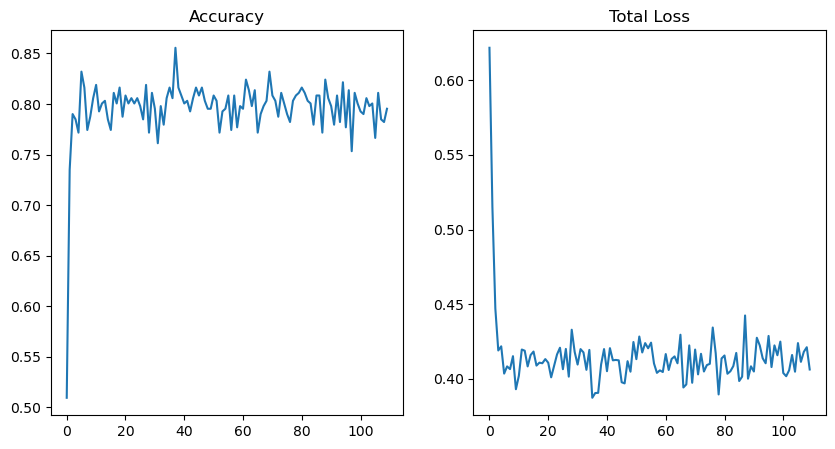

In [413]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(acc_list)
plt.subplot(1,2,2)
plt.title("Total Loss")
plt.plot(ll)

In [414]:
@torch.inference_mode()
def evaluate(model):
    model.eval()
    
    total_obj = 0
    total_loss = []
    correct = 0
    y_true_list = []
    prediction_list = []
    
    for x,y in tqdm(train_dataloader, desc="Evaluation"):
        
        # Saving True values of y_true
        y_true_list += y.numpy().tolist()
        
        output = model.forward(x)
        output = output.resize(len(y))
        
        # Predicted classes
        predicted_classes = [1 if i >= 0.5 else 0 for i in output]
        prediction_list += predicted_classes
        
        loss = loss_fn(output, y)
        
        correct += sum(y.numpy() == predicted_classes).item()
        total_obj+= len(y)
        total_loss += [loss.item()]
    
    
    # calcualte metrics
    accuracy = correct / total_obj
    
    return total_loss, accuracy, y_true_list, prediction_list

In [415]:
ll_list, acc, y_true_list, prediction_list = evaluate(model)
print(acc)

Evaluation: 100%|█| 48/4

0.9028871391076115


Text(0.5, 23.52222222222222, 'Model output')

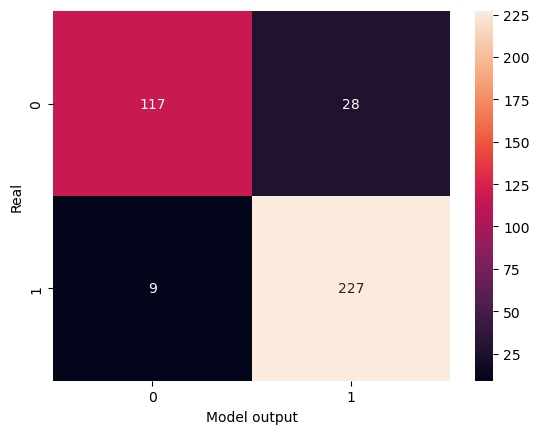

In [416]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_true_list,prediction_list), annot = True, fmt = '')
plt.ylabel("Real")
plt.xlabel("Model output")

In [417]:
from sklearn.metrics import classification_report

In [418]:
# RESULT: Weighted precision 96%  Weighted recall 96% 

print(classification_report(y_true_list,prediction_list))

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86       145
         1.0       0.89      0.96      0.92       236

    accuracy                           0.90       381
   macro avg       0.91      0.88      0.89       381
weighted avg       0.90      0.90      0.90       381



# Cравниваем с классическим catboost классификатором

In [186]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(verbose= False)

catboost_model.fit(X_train,y_train)

In [187]:
prediction = catboost_model.predict(X_test)

In [188]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96        67
         1.0       0.97      0.99      0.98       121

    accuracy                           0.97       188
   macro avg       0.98      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188

